Auteurs:
- Louis PAGNIER
- Léo SRON
- Anthony BERNARD
- Junyi LI
- David FRECON

# Détection d'anomalies dans le système SWaT (Secure Water Treatment)

## Introduction

Dans ce notebook, nous allons essayer de prédire les attaques sur le système SWaT à partir des données fournies dans le dataset SWaT.A3 qui répertorie des données du 20 Juillet 2019.   
Dans ce jeu de données, 6 attaques ont été réalisées sur le système SWaT à des moments différents de la journée.

## Import des librairies

In [24]:
import pandas as pd
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_exploration_utils import *
from mlsecu.data_preparation_utils import *
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt

## Définition des fonctions

Dans un premier temps, nous allons nous concentrer uniquement sur les capteurs du système et laisser de côté les pompes.

In [48]:
sensor_regex = re.compile(r'^(A|F|L|P)IT \d{3}$')

In [17]:
def load_df(name, only_sensors=True):
    """
    Load the dataset from the excel file.
    The parameter only_sensors allows to load only the sensors and not the pumps.
    """
    df = pd.read_excel(name, skiprows=[0, 2])
    if only_sensors:
        sensor_cols = [col for col in df.columns if sensor_regex.match(col) or col in ['Timestamp', 'Attack', 'Label']]
        df = df[sensor_cols]
    return df

In [18]:
def clean_df(df):
    """
    Clean the dataset by removing NaN values and replacing them by the corresponding missing values.
    """
    df['Attack'] = df['Attack'].fillna('benign')
    df['Label'] = df['Label'].fillna(0)
    df['Label'] = df['Label'].astype(int)
    df = df.dropna(axis=0)
    return df

In [45]:
def extract_features(df):
    """
    Extract the features from the dataset. (only the sensors)
    """
    sensor_cols = [col for col in df.columns if sensor_regex.match(col)]
    df_X = df[sensor_cols]
    return df_X

def extract_labels(df, label_col='Label'):
    """
    Extract the labels from the dataset.
    """
    return df[label_col]

In [84]:
def visualize_df(df, outlier_col='Label', title='PCA'):
    """
    Visualize the dataset by using PCA to reduce the dimensionality.
    """
    df_X = extract_features(df)
    df_y = extract_labels(df, outlier_col)
    
    pca = PCA(n_components=2)
    df_X_pca = pca.fit_transform(df_X)
    df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
    df_X_pca['Label'] = df_y
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    targets = [0, 1]
    colors = ['b', 'r']
    for target, color in zip(targets, colors):
        indices_to_keep = df_X_pca['Label'] == target
        ax.scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    

In [85]:
def visualize_dfs(dfs, outlier_cols=['Label'], titles=['PCA']):
    """
    Visualize multiple datasets in a row by using PCA.
    """
    fig, axs = plt.subplots(1, len(dfs), figsize=(10, 5))
    for i, df in enumerate(dfs):
        df_X = extract_features(df)
        df_y = extract_labels(df, outlier_cols[i])
        
        pca = PCA(n_components=2)
        df_X_pca = pca.fit_transform(df_X)
        df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
        df_X_pca['Label'] = df_y
        
        axs[i].set_xlabel('PC1')
        axs[i].set_ylabel('PC2')
        axs[i].set_title(titles[i])
        targets = [0, 1]
        colors = ['b', 'r']
        for target, color in zip(targets, colors):
            indices_to_keep = df_X_pca['Label'] == target
            axs[i].scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
        axs[i].legend(targets)
        axs[i].grid()
    plt.show()

In [72]:
def get_confusion_matrix(df, prediction_col, label_col):
    """
    Compute the confusion matrix from the dataset.
    """
    TP = df[(df[prediction_col] == 1) & (df[label_col] == 1)].shape[0]
    TN = df[(df[prediction_col] == 0) & (df[label_col] == 0)].shape[0]
    FP = df[(df[prediction_col] == 1) & (df[label_col] == 0)].shape[0]
    FN = df[(df[prediction_col] == 0) & (df[label_col] == 1)].shape[0]
    return TP, TN, FP, FN

In [73]:
def compute_accuracy(df, prediction_col, label_col='Label'):
    """
    Compute the accuracy from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return (TP + TN) / (TP + TN + FP + FN)

def compute_precision(df, prediction_col, label_col='Label'):
    """
    Compute the precision from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FP)

def compute_recall(df, prediction_col, label_col='Label'):
    """
    Compute the recall from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FN)

In [74]:
def display_metrics(df, prediction_col, label_col='Label'):
    """
    Display the accuracy, precision and recall from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    print('Accuracy: {:.2f}'.format((TP + TN) / (TP + TN + FP + FN)))
    print('Precision: {:.2f}'.format(TP / (TP + FP)))
    print('Recall: {:.2f}'.format(TP / (TP + FN)))

## Chargement des données

Avant de commencer, nous allons charger les données du dataset SWaT.A3.

In [89]:
df = load_df('data/SWaT.A3_dataset_Jul 19_labelled.xlsx')
df = clean_df(df)
df.head()

,Timestamp,Attack,Label,FIT 101,LIT 101,AIT 201,AIT 202,AIT 203,FIT 201,AIT 301,...,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,PIT 501,PIT 502,PIT 503,FIT 601
0,2019-07-20T04:30:00Z,benign,0.0,0.0,729.8658,142.527557,9.293002,198.077423,2.335437,8.522921,...,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,167.601257,2.963509,119.921173,0.00032
1,2019-07-20T04:30:01Z,benign,0.0,0.0,729.4340,142.527557,9.293002,198.385025,2.335437,8.522921,...,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,167.601257,2.963509,119.921173,0.00032
2,2019-07-20T04:30:02.004013Z,benign,0.0,0.0,729.1200,142.527557,9.293002,198.436300,2.335437,8.522921,...,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,167.601257,2.963509,119.921173,0.00032
3,2019-07-20T04:30:03.004013Z,benign,0.0,0.0,728.6882,142.527557,9.289157,198.667000,2.335437,8.522921,...,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,167.601257,2.963509,119.921173,0.00032
4,2019-07-20T04:30:04Z,benign,0.0,0.0,727.7069,142.527557,9.289157,198.897720,2.335437,8.522921,...,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,167.601257,2.963509,119.921173,0.00032


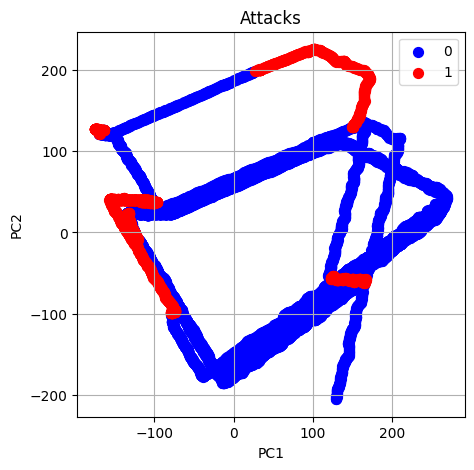

In [90]:
visualize_df(df, title='Attacks')

## Détection d'anomalies

Nous allons désormais utiliser les fonctions définies précédemment pour détecter les anomalies dans le dataset.

### Isolation Forest

La première méthode que nous allons utiliser pour déterminer les outliers est Isolation Forest. Cette méthode est basée sur la construction d'arbres de décision aléatoires. Elle permet de déterminer les outliers en fonction du nombre de splits nécessaires pour isoler un point. Plus le nombre de splits est faible, plus le point est considéré comme un outlier.

In [78]:
# Remove extra columns (These columns must not be used for the detection of outliers)
df_if = extract_features(df).copy()

In [79]:
indexes = get_list_of_if_outliers(df_if, 0.03)
df_if['if_outliers'] = 0
df_if.loc[indexes, 'if_outliers'] = 1

In [80]:
# restore extra columns
df_if['Timestamp'] = df['Timestamp']
df_if['Attack'] = df['Attack']
df_if['Label'] = df['Label']

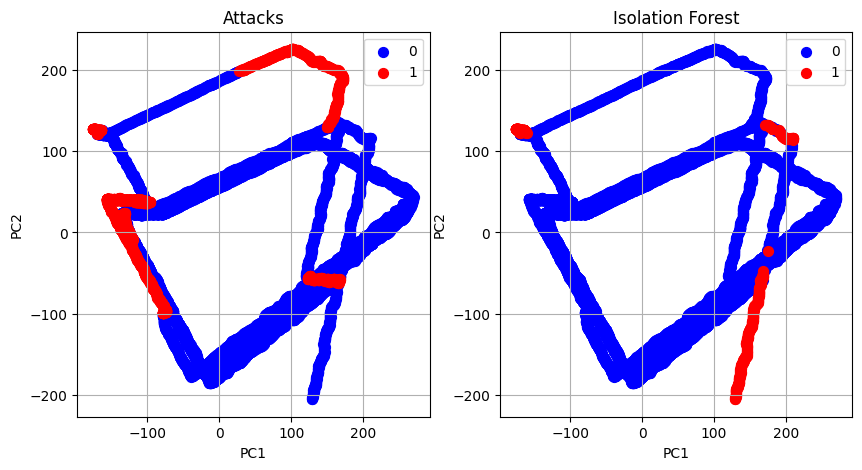

In [87]:
visualize_dfs([df, df_if], ['Label', 'if_outliers'], titles=['Attacks', 'Isolation Forest'])

In [88]:
display_metrics(df_if, 'if_outliers')

Accuracy: 0.82
Precision: 0.32
Recall: 0.06


On peut voir que la méthode Isolation Forest permet de détecter les anomalies avec une accuracy de 0.82, une precision de 0.32 et un recall de 0.06.  
Ces résultats sont assez mauvais. Dans notre cas, la métrique la plus importante est le recall car elle indique le nombre d'attaques détectées par rapport au nombre d'attaques réelles.